In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

In [2]:
# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))  # Assuming masks have same name but .png
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [3]:
# U-Net model (basic structure)
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Downsample to 64x64
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),  # Upsample to 128x128
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc = self.encoder(x)  # Downsample
        out = self.decoder(enc)  # Upsample
        return out


In [4]:
# 3. Load Pre-trained Weights
def load_model(weights_path, num_classes):
    model = HResNetSegmentation(num_classes=num_classes)
    checkpoint = torch.load(weights_path, map_location=torch.device('cpu'))
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict, strict=False)
    return model

In [5]:
# Weighted loss function
def weighted_bce_loss(output, target, weight):
    bce_loss = nn.BCELoss(reduction='none')
    loss = bce_loss(output, target)
    loss = loss * weight
    return loss.mean()


In [6]:
TRAIN_IMAGE_DIR = r"C:\Users\lhoan\OneDrive\Bureau\ias_data\Train\images"
TRAIN_MASK_DIR = r"C:\Users\lhoan\OneDrive\Bureau\ias_data\Train\masks"
TEST_IMAGE_DIR = r"C:\Users\lhoan\OneDrive\Bureau\ias_data\Test\images"
TEST_MASK_DIR = r"C:\Users\lhoan\OneDrive\Bureau\ias_data\Test\masks"

In [7]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for faster training
    transforms.ToTensor()
])

In [8]:
# Datasets and Dataloaders
train_dataset = SegmentationDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, transform)
test_dataset = SegmentationDataset(TEST_IMAGE_DIR, TEST_MASK_DIR , transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [9]:

# Model, optimizer, and training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()

        # Calculate class weights based on mask distribution
        weights = torch.ones_like(masks)
        weights[masks == 1] = 5.0  # Weight foreground class higher

        optimizer.zero_grad()
        outputs = model(images)
        loss = weighted_bce_loss(outputs, masks, weights)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

# Save the model
torch.save(model.state_dict(), "segmentation_model.pth")

print("Training complete.")

Epoch [1/2], Loss: 0.0706
Epoch [2/2], Loss: 0.0813
Training complete.


In [12]:
# Load the model
model = UNet()
model.load_state_dict(torch.load("segmentation_model.pth"))
model.eval()  # Set the model to evaluation mode

C:\Users\lhoan\AppData\Local\Temp\ipykernel_15012\1086268995.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("segmentation_model.pth"))


UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Sigmoid()
  )
)

In [13]:
from PIL import Image
from torchvision import transforms

# Preprocessing function
def preprocess_image(image_path, target_size=(128, 128)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

In [14]:
import torch

# Inference function
def predict(image_path, model, device):
    model = model.to(device)
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        output = model(image)
    return output.squeeze(0).cpu()  # Remove batch dimension and bring back to CPU

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Visualization function
def visualize_results(image_path, prediction):
    original_image = Image.open(image_path).convert("RGB")
    prediction = prediction.squeeze().numpy()  # Convert tensor to numpy array

    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="gray")
    plt.axis("off")

    # Overlay mask on the original image
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(original_image)
    plt.imshow(prediction, cmap="jet", alpha=0.5)  # Overlay with transparency
    plt.axis("off")

    plt.show()

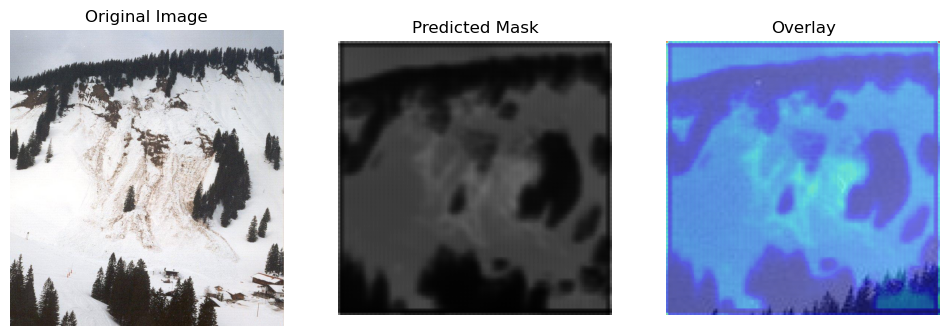

In [18]:
# Define paths
image_path = r"C:\Users\lhoan\OneDrive\Bureau\ias_data\2000-04-17 spitzingsee firstalm (13).jpg"  # Replace with the path to your test image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Predict and visualize
prediction = predict(image_path, model, device)
visualize_results(image_path, prediction)

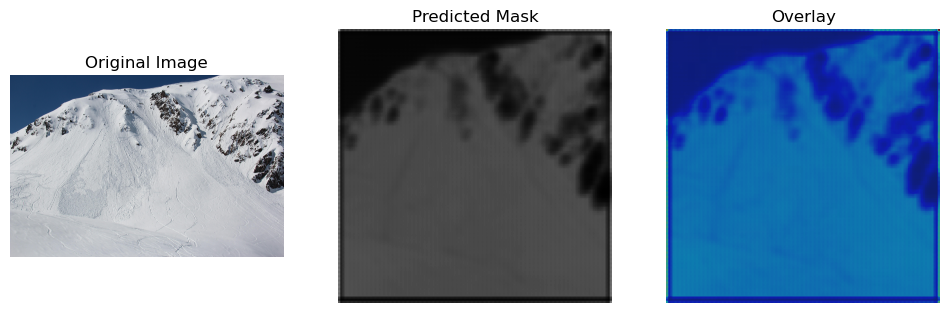

In [19]:
# Define paths
image_path = r"C:\Users\lhoan\OneDrive\Bureau\ias_data\2015-03-28 hochfuegen (9).jpg"  # Replace with the path to your test image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Predict and visualize
prediction = predict(image_path, model, device)
visualize_results(image_path, prediction)


In [22]:

def visualize_results_contrast(image_path, prediction, threshold=0.5):
    original_image = Image.open(image_path).convert("RGB")
    prediction = prediction.squeeze().numpy()  # Convert tensor to numpy array

    # Create a binary mask: 1 for bright pixels (white), 0 for dark pixels (black)
    binary_mask = (prediction > threshold).astype(np.float32)

    # Create a black canvas for contrast
    black_background = np.zeros_like(binary_mask)

    plt.figure(figsize=(12, 6))

    # Original image (for reference)
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    # Predicted mask with black background
    plt.subplot(1, 3, 2)
    plt.title("Segmented Mask on Black Background")
    plt.imshow(black_background, cmap="gray")  # Display black background
    plt.imshow(binary_mask, cmap="gray", alpha=1)  # Overlay the white mask
    plt.axis("off")

    # Overlay mask directly on black
    plt.subplot(1, 3, 3)
    plt.title("Black with Segmentation")
    plt.imshow(binary_mask, cmap="gray")  # Display only white mask
    plt.axis("off")

    plt.show()

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Visualization function
def visualize_results(image_path, prediction):
    original_image = Image.open(image_path).convert("RGB")
    prediction = prediction.squeeze().numpy()  # Convert tensor to numpy array

    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="jet")
    plt.axis("off")

    # Overlay mask on the original image
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    #plt.imshow(original_image)
    plt.imshow(prediction, cmap="jet", alpha=0.5)  # Overlay with transparency
    plt.axis("off")

    plt.show()

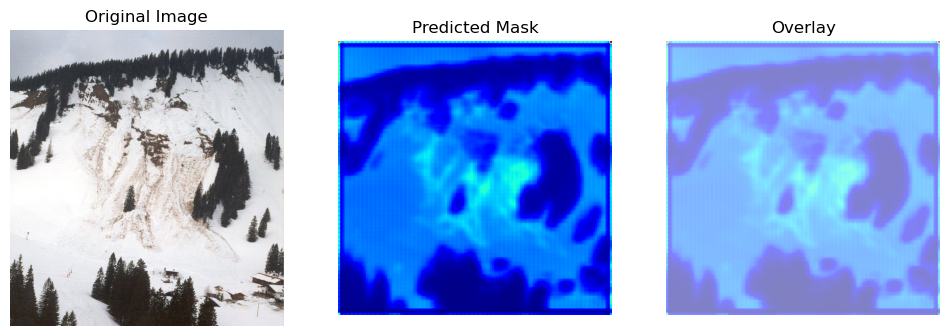

In [42]:
# Define paths
image_path = r"C:\Users\lhoan\OneDrive\Bureau\ias_data\2000-04-17 spitzingsee firstalm (13).jpg"  # Replace with the path to your test image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Predict and visualize
prediction = predict(image_path, model, device)
visualize_results(image_path, prediction)

In [51]:
def show_prediction_only_dynamic_threshold(prediction, percentile=90):
    """
    Display binary prediction with a dynamic threshold based on the percentile.
    """
    # Convert the prediction tensor to a numpy array
    prediction = prediction.squeeze().numpy()

    # Calculate dynamic threshold
    threshold = np.percentile(prediction, percentile)
    print(f"Dynamic threshold set at: {threshold}")

    # Apply threshold to create a binary mask
    binary_mask = (prediction > threshold).astype(np.float32)

    # Plot the binary mask
    plt.figure(figsize=(6, 6))
    plt.title("Prediction Only")
    plt.imshow(binary_mask, cmap="gray")
    plt.axis("off")
    plt.show()

Dynamic threshold set at: 0.024970864318311223


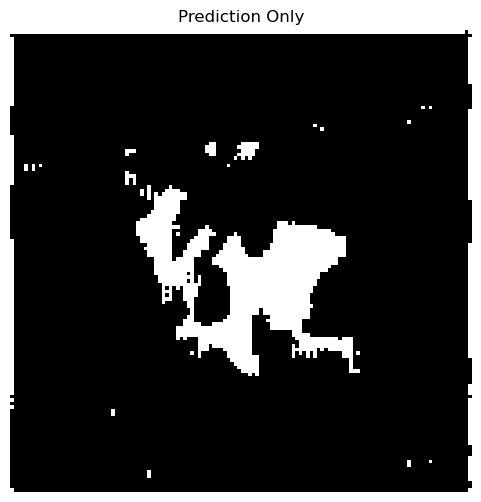

In [52]:
show_prediction_only_dynamic_threshold(prediction, percentile=90)

In [ ]:
def show_prediction_only_dynamic_threshold(prediction, percentile=90):
    """
    Display binary prediction with a dynamic threshold based on the percentile.
    """
    # Convert the prediction tensor to a numpy array
    prediction = prediction.squeeze().numpy()

    # Calculate dynamic threshold
    threshold = np.percentile(prediction, percentile)
    print(f"Dynamic threshold set at: {threshold}")

    # Apply threshold to create a binary mask
    binary_mask = (prediction > threshold).astype(np.float32)

    # Plot the binary mask
    plt.figure(figsize=(6, 6))
    plt.title("Prediction Only")
    plt.imshow(binary_mask, cmap="gray")
    plt.axis("off")
    plt.show()

In [57]:
def show_prediction_overlay_red(image_path, prediction, percentile=90):
    """
    Overlay binary prediction (in red) on the original image using a dynamic threshold.
    """
    try:
        # Load the original image
        original_image = np.array(Image.open(image_path).convert("RGB"))
        print(f"Original image shape: {original_image.shape}")

        # Convert the prediction tensor to a numpy array
        prediction = prediction.squeeze().numpy()
        print(f"Prediction shape: {prediction.shape}")

        # Calculate dynamic threshold
        threshold = np.percentile(prediction, percentile)
        print(f"Dynamic threshold set at: {threshold}")

        # Apply threshold to create a binary mask
        binary_mask = (prediction > threshold).astype(np.float32)

        # Resize the binary mask to match the image size
        if binary_mask.shape != original_image.shape[:2]:
            binary_mask_resized = resize(
                binary_mask, 
                original_image.shape[:2], 
                order=0, 
                preserve_range=True, 
                anti_aliasing=False
            ).astype(np.float32)
        else:
            binary_mask_resized = binary_mask

        # Create a red overlay for the mask
        overlay = np.zeros_like(original_image)
        overlay[:, :, 0] = (binary_mask_resized * 255).astype(np.uint8)  # Red channel

        # Combine the original image and the red mask
        overlayed_image = np.clip(original_image + overlay, 0, 255).astype(np.uint8)

        # Plot the overlayed image
        plt.figure(figsize=(8, 8))
        plt.title("Prediction Overlay in Red")
        plt.imshow(overlayed_image)
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

In [58]:
show_prediction_overlay_red(image_path, prediction, percentile=90)

Original image shape: (796, 735, 3)
Prediction shape: (128, 128)
Dynamic threshold set at: 0.024970864318311223
An error occurred: name 'resize' is not defined


In [ ]:

def show_prediction_overlay_red(image_path, prediction, percentile=90):
    """
    Overlay binary prediction (in red) on the original image using a dynamic threshold.
    """
    try:
        # Load the original image
        original_image = np.array(Image.open(image_path).convert("RGB"))
        print(f"Original image shape: {original_image.shape}")

        # Convert the prediction tensor to a numpy array
        prediction = prediction.squeeze().numpy()
        print(f"Prediction shape: {prediction.shape}")

        # Calculate dynamic threshold
        threshold = np.percentile(prediction, percentile)
        print(f"Dynamic threshold set at: {threshold}")

        # Apply threshold to create a binary mask
        binary_mask = (prediction > threshold).astype(np.float32)

        # Resize the binary mask to match the image size using Pillow
        binary_mask_resized = Image.fromarray(binary_mask).resize(
            (original_image.shape[1], original_image.shape[0]),  # (width, height)
            resample=Image.NEAREST
        )
        binary_mask_resized = np.array(binary_mask_resized)

        # Create a red overlay for the mask
        overlay = np.zeros_like(original_image)
        overlay[:, :, 0] = (binary_mask_resized * 255).astype(np.uint8)  # Red channel

        # Combine the original image and the red mask
        overlayed_image = np.clip(original_image + overlay, 0, 255).astype(np.uint8)

        # Plot the overlayed image
        plt.figure(figsize=(8, 8))
        plt.title("Prediction Overlay in Red")
        plt.imshow(overlayed_image)
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
binary_mask